# LAB 03.02 - Timeseries model

In [2]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()


replicating local resources


In [ ]:
from local.lib.rlxmoocapi import submit, session
session.LoginSequence(endpoint=init.endpoint, course_id=init.course_id, lab_id="L03.02", varname="student");

logging in as cristian.penagos@udea.edu.co... please wait
using course session ai4eng.v1.udea.r3::2024.1
success!! you are logged in


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from local.lib import timeseries as ts
import pandas as pd
import os
from IPython.display import Image
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

## A synthetic timeseries

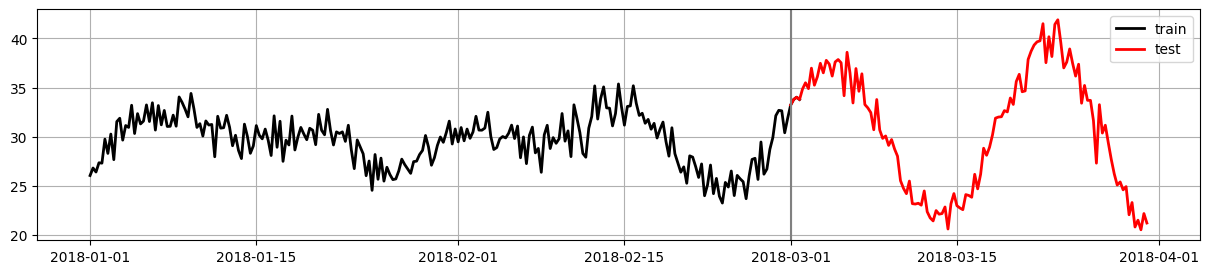

In [4]:

date_split = "2018-03-01"

idx = pd.date_range("2018-01-01", "2018-03-31", freq="6h")
i = np.linspace(-5,4,len(idx))
i = np.linspace(np.random.random()*5-5,np.random.random()*5+2,len(idx))
t = np.log(i**2+.3)*np.cos(4*i)
t += (np.random.normal(size=len(idx))*.4)
t = np.round(t*3+30,3)
d = pd.DataFrame(np.r_[[t]].T, columns=["signal"], index=idx)
d.index.name="date"

plt.figure(figsize=(15,3))
plt.plot(d[:date_split].index, d[:date_split].signal, color="black", lw="2", label="train");
plt.plot(d[date_split:].index, d[date_split:].signal, color="red", lw="2", label="test");
plt.axvline(date_split, color="grey"); plt.legend();plt.grid();
signal = d


In [5]:
d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 357 entries, 2018-01-01 00:00:00 to 2018-03-31 00:00:00
Freq: 6H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   signal  357 non-null    float64
dtypes: float64(1)
memory usage: 13.7 KB


In [6]:
d.head(10)

,signal
date,
2018-01-01 00:00:00,26.064
2018-01-01 06:00:00,26.829
2018-01-01 12:00:00,26.420
2018-01-01 18:00:00,27.361
2018-01-02 00:00:00,27.321
2018-01-02 06:00:00,29.762
2018-01-02 12:00:00,28.312
2018-01-02 18:00:00,30.276
2018-01-03 00:00:00,27.676


## Task 1. Build a time series training dataset

In this task, starting off from the time signal above, you must build an **annotated dataset** so that at any time instant **given the three last `n_timesteps_lookback` signal values and the current one** we want to **predict the next one**.

Complete the following function so that when receiving a time indexed dataframe such as the one above, the resulting dataframe is such that:

- the column **signal** is left untouched
- there are `n_timesteps_lookback`+1 new columns:
    - the column **signal+1** contains the signal one time step into the future
    - the columns **signal-1**, **signal-2**, etc. contain the signal one, two, etc. time steps into the past.

- the resulting dataset contains (`n_timesteps_lookback`+1) rows less than the original dataset, one due to the **signal+1** column and the rest for the **signal-x** columns. For instance, if the original dataset contained 357 rows, with `n_timesteps_lookback=3` the resulting dataframe will contain 353 rows.

**Hint**: use [`pandas.DataFrame.join`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html), [`pandas.DataFrame.shift`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) and [`pandas.DataFrame.dropna`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

For instance, with this input

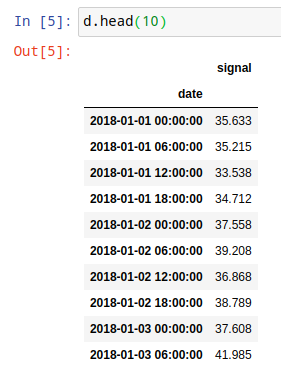

In [ ]:
Image("local/imgs/df_tseries1.png")

you should produce the following output

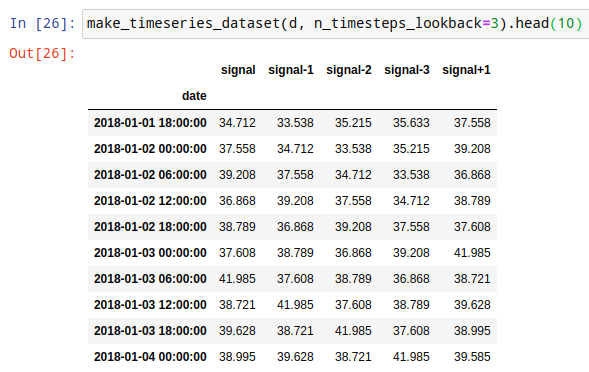

In [ ]:
Image("local/imgs/df_tseries2.png")

In [7]:
def make_timeseries_dataset(d, n_timesteps_lookback):
    import pandas as pd

    columnasDespl = []
    colPred = pd.DataFrame()
    for i in range(n_timesteps_lookback, -1, -1): # Num desplazamiento, Parada, Salto
      columna = d.shift(-i)
      columnasDespl.append(columna)


    df = pd.concat(columnasDespl, axis=1)

    columna_nombres = ['signal-' + str(i) for i in range(n_timesteps_lookback + 1)]
    df.columns = columna_nombres
    df = df.dropna()


    colPred["signal+1"] = d.shift(- n_timesteps_lookback - 1)
    df = pd.concat([df, colPred], axis=1)
    df = df.dropna()

    df = df.rename(columns={"signal-0":"signal"})

    #df.info()

    return df
#d.dropna()


test your code

In [ ]:
make_timeseries_dataset(d, n_timesteps_lookback=3)


,signal,signal-1,signal-2,signal-3,signal+1
date,,,,,
2018-01-01 00:00:00,35.422,36.748,36.817,35.706,37.986
2018-01-01 06:00:00,37.986,35.422,36.748,36.817,36.721
2018-01-01 12:00:00,36.721,37.986,35.422,36.748,34.822
2018-01-01 18:00:00,34.822,36.721,37.986,35.422,36.553
2018-01-02 00:00:00,36.553,34.822,36.721,37.986,39.366
...,...,...,...,...,...
2018-03-29 00:00:00,29.927,27.150,25.451,25.680,29.579
2018-03-29 06:00:00,29.579,29.927,27.150,25.451,31.499
2018-03-29 12:00:00,31.499,29.579,29.927,27.150,32.349


In [ ]:
pd.concat([d,d.shift(-1)], axis=1)

,signal,signal
date,,
2018-01-01 00:00:00,35.829,34.503
2018-01-01 06:00:00,34.503,32.259
2018-01-01 12:00:00,32.259,33.636
2018-01-01 18:00:00,33.636,29.990
2018-01-02 00:00:00,29.990,28.965
...,...,...
2018-03-30 00:00:00,37.580,38.580
2018-03-30 06:00:00,38.580,37.110
2018-03-30 12:00:00,37.110,36.574


In [ ]:
type(d)

pandas.core.frame.DataFrame

In [ ]:
make_timeseries_dataset(d, n_timesteps_lookback=3).head(30)

,signal,signal-1,signal-2,signal-3,signal+1
date,,,,,
2018-01-01 00:00:00,35.422,36.748,36.817,35.706,37.986
2018-01-01 06:00:00,37.986,35.422,36.748,36.817,36.721
2018-01-01 12:00:00,36.721,37.986,35.422,36.748,34.822
2018-01-01 18:00:00,34.822,36.721,37.986,35.422,36.553
2018-01-02 00:00:00,36.553,34.822,36.721,37.986,39.366
2018-01-02 06:00:00,39.366,36.553,34.822,36.721,36.018
2018-01-02 12:00:00,36.018,39.366,36.553,34.822,34.194
2018-01-02 18:00:00,34.194,36.018,39.366,36.553,36.455
2018-01-03 00:00:00,36.455,34.194,36.018,39.366,33.845


**submit your answer**

In [ ]:
student.submit_task(globals(), task_id="task_01");

error: ERROR EXECUTING YOUR CODE
---------------------------------
Traceback (most recent call last):
  File "<string>", line 652, in run
TypeError: make_timeseries_dataset() got an unexpected keyword argument 'signal'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/calling_script.py", line 24, in <module>
    r = eval("xtzirnud.{}(source_functions, source_variables, 'cristian.penagos@udea.edu.co')".format(grader_function_name), namespace)
  File "<string>", line 1, in <module>
  File "/content/xtzirnud.py", line 37, in grader_01
    return grader.run()
  File "<string>", line 710, in run
local.lib.rlxmoocapi.session.RLXMOOCException: error: ERROR GRADING YOUR SOLUTION
----------------------
make_timeseries_dataset() got an unexpected keyword argument 'signal' (set session.debug=True for tracebacks)
 (set session.debug=True for tracebacks)

## Task 2. Manually apply a regression model to create predictions

Complete the following function to apply the a linear regression model to a dataframe such as the resulting one from the previous task:

$$\hat{y} = w_0 + w_1s + w_2s_{-1} + w_3s_{-2} + w_4s_{-3} ... $$

where $s$ corresponds to the column named `signal`, $s_{-1}$ to the column named `signal-1`, etc.

Observe that:

- column `signal+1` is not used, as it is the expected prediction. You will use it in the next task.
- you will have `n_timesteps_lookback`+2 $w$ parameters, since you will have one per each `n_timesteps_lookback`, plus $w_0$, plus $w_1$

Expect the function arguments as follow:

- `td`: a Pandas dataframe such as the output of the function `make_timeseries_dataset` of the previous task, with exactly the same column names
- `w`: a Numpy array with `n_timesteps_lookback`+2 elements in the order $[w_0, w_1, ...]$

**Warn**:  the DataFrame `td` may contain any number of lookback columns and might be in **any order**

**Challenge**: solve it with one single line of Python code

**EXAMPLE**: For the following dataframe and $w$

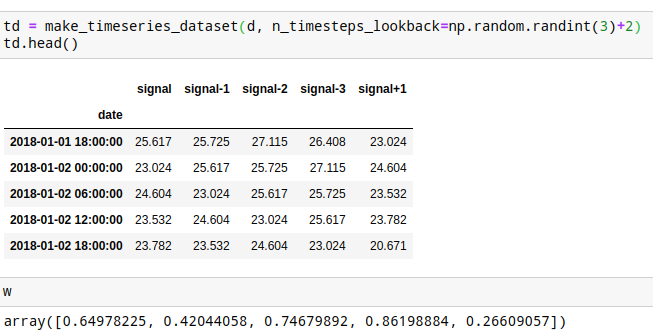

In [ ]:
Image("local/imgs/ts_reg_1.png")

you should get the following results

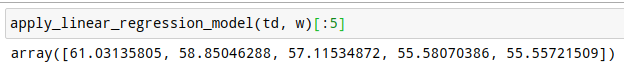

In [ ]:
Image("local/imgs/ts_reg_2.png")

In [ ]:
def apply_linear_regression_model(td, w):
    r = ... # YOUR SOLUTION HERE
    return r

In [60]:
#df.info()
dato = td.iloc[0,0]

filas = td.shape[0]                  #Numero de filas td para controlar el ciclo al cambiar de fila
#print(w[2])
sesgo = w[0]                            #Primera Posicion de w
sumaTemp = 0
suma = []
nomCol = ''

for fila in filas:
  for i in range(0, len(w), 1):
    nomCol = td.columns[i]

    if nomCol == 'signal':
      dato = td.iloc[0, td.columns.get_loc("signal")]



  #nomColumna =
#suma.append(nomCol)
#prediccion = w[wPosition] +

print(suma)


['signal+1', 'signal-2', 'signal-3', 'signal-1', 'signal']


In [31]:
variable = 1
nomCol = td.columns[variable]
print(nomCol)


signal-1


In [65]:
print(td.shape[0])

353


In [36]:
print(len(w))

4


In [13]:
td.head(5)

,signal,signal-1,signal+1,signal-2
date,,,,
2018-01-01 00:00:00,26.420,26.829,27.361,26.064
2018-01-01 06:00:00,27.361,26.420,27.321,26.829
2018-01-01 12:00:00,27.321,27.361,29.762,26.420
2018-01-01 18:00:00,29.762,27.321,28.312,27.361
2018-01-02 00:00:00,28.312,29.762,30.276,27.321


### test your code manually

observe how we permute the columns order

In [54]:
td = make_timeseries_dataset(d, n_timesteps_lookback=np.random.randint(3)+2)
td = td[np.random.permutation(td.columns)]
td.head()

,signal+1,signal-2,signal-3,signal-1,signal
date,,,,,
2018-01-01 00:00:00,27.321,26.829,26.064,26.420,27.361
2018-01-01 06:00:00,29.762,26.420,26.829,27.361,27.321
2018-01-01 12:00:00,28.312,27.361,26.420,27.321,29.762
2018-01-01 18:00:00,30.276,27.321,27.361,29.762,28.312
2018-01-02 00:00:00,27.676,29.762,27.321,28.312,30.276


In [55]:
w = np.random.random(len(td.columns))
w

array([0.0533528 , 0.43406295, 0.68383014, 0.63756694, 0.3780717 ])

In [ ]:
apply_linear_regression_model(td[np.random.permutation(td.columns)], w)[:5]

date
2018-01-01 00:00:00    42.191919
2018-01-01 06:00:00    43.197493
2018-01-01 12:00:00    42.442498
2018-01-01 18:00:00    42.408933
2018-01-02 00:00:00    43.699815
                         ...    
2018-03-29 06:00:00    31.214083
2018-03-29 12:00:00    33.641273
2018-03-29 18:00:00    35.310935
2018-03-30 00:00:00    35.968426
2018-03-30 06:00:00    38.003600
Freq: 6H, Length: 354, dtype: float64


TypeError: 'NoneType' object is not subscriptable

**submit your answer**

In [ ]:
student.submit_task(globals(), task_id="task_02");

## Task 3: Measure trend prediction

You will now use the predictions to measure **trend accuracy**. We will compare any predictions which are given to us with the actual next value in column **signal+1** in the following way

- if **signal+1>signal** and ALSO your **prediction>signal**, then your model has a **correct trend prediction** regardless how different are **signal+1** and **prediction**
- if **signal+1<=signal** and ALSO your **prediction<=signal**, then your model has a **correct trend prediction** regardless how different are **signal+1** and **prediction**
- otherwise, your model has an **incorrect prediction**

Complete the following function such that when receiving a dataframe such as the resulting one from task 1 above, and a `pd.Series` with the same index and price predictions, computes the accuracy of the predictions (the percentage of correct predictions).

The accuracy must be a `float` and its correctness will be checked up to 2 decimal places.

**Challenge**: solve it with one single line of Python code.

**EXAMPLE**: for the following time series dataset

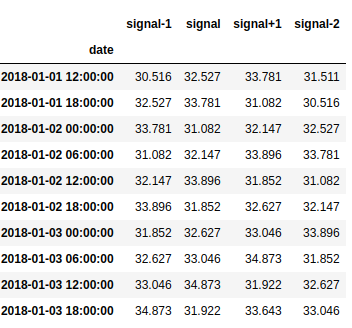

In [ ]:
Image("local/imgs/ts_reg_3.png")

And the following predictions

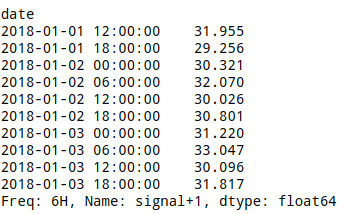

In [ ]:
Image("local/imgs/ts_reg_4.png")

The trend accuracy is `0.4` since the trend is correctly hit by the predictions on rows 1, 4, 7 and 8 (assuming the first row is numbered as 0)

In [ ]:
def measure_trend_accuracy(td, preds):
    r = ... # YOUR CODE HERE
    return r

### test your code manually


In [ ]:
td = make_timeseries_dataset(d, n_timesteps_lookback=np.random.randint(3)+2).iloc[:10]
td

In [ ]:
preds = td['signal'] + np.round(np.random.random()*4-2,3)
preds

In [ ]:
measure_trend_accuracy(td, preds)

**submit your answer**

In [ ]:
student.submit_task(globals(), task_id="task_03");